# 第12組_社群媒體分析_期末專案_BERT-NER

## 組別：Group 12
## 題目：PTT論壇AI相關議題的語料分析與趨勢探勘
### 使用工具：Python

M134020005 馮祐倫  
M134020051 柯昆霖

報告影片連結：https://youtu.be/NcM5DaE0uTg


## 目的
2023 年起，生成式 AI 帶來了前所未有的變革浪潮。從 ChatGPT 到 Midjourney、從人工到自動化，AI 正以前所未有的速度滲透人們的工作與生活。  
而在台灣最具代表性的網路論壇之一——PTT，鄉民們也開始熱烈討論這波浪潮帶來的機會與焦慮。

本專案計畫分析和說明以下三個核心問題：

1. PTT 社群如何看待 AI 在職場與科技工作的角色與影響？

2. 各主要實體（如：公司、技術、人物等）在討論中扮演什麼樣的網絡位置與影響力？

3. 不同主題下的情緒傾向與輿論熱點為何？


透過各種不同的分析，進一步揭示各實體在社群中的連結強度、討論中心性與潛在社群結構：

1. 情緒分析 (Sentiment Analysis)

    目的：判斷貼文中對 AI 的整體情感傾向（正向、中立、負向）。

    應用：了解網友對 AI 技術、AI 應用在工作上，以及 AI 對職場未來影響的情緒態度，並進一步探索情緒隨時間或議題的變化趨勢。

2. 主題模型分析 (Topic Modeling)

    目的：藉由 BERTopic 方法，自動挖掘貼文中的主題結構，找出幾大核心討論議題。

    應用：了解在「AI+工作」範疇內，網友最關注哪些面向（例如「AI 自動化取代工作」、「AI 招募面試應用」、「AI 技能學習建議」……），並分析每個主題的情緒分佈與實體共現情況。

3. 命名實體識別 (NER)

    目的：自動偵測並抽取貼文中的組織（ORG）、人物（PERSON）、產品（PRODUCT）、技術（TECH）等實體。

    應用：辨識出在 AI 討論中最常被提及的公司（如台積電、NVIDIA）、研究單位、意見領袖，或是關鍵技術名詞，為後續網路圖與主題建模提供實體基礎。

4. 網路圖構建 (Network Graph Analysis)

    目的：將貼文中的實體 (經由 NER) 與關鍵詞或使用者互動關係視覺化為節點與邊，構建實體共現網路或使用者互動網路。

    應用：揭示 AI 議題中各實體之間的關聯強度（例如哪些公司或技術一起被討論最多）、意見領袖的社群結構，以及不同主題或情緒社群的網絡分布。


綜合以上，能更立體地描繪出台灣論壇使用者在 AI 職場議題中的討論趨勢、關注焦點與情緒反應。


In [ ]:
import pandas as pd
import re
import ast

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

## 資料集概覽

此資料集收集自台灣的社群媒體平台 PTT。PTT「工作」、「職場」、「科技工作」三個版中，針對含有 “AI” 關鍵字的貼文。資料收集範圍從 2024 年 5 月 1 日到 2025 年 5 月 1 日，共包含 2456 筆資料。

## 資料欄位說明

資料集包含以下 10 個欄位：

1. `system_id`: 系統編號
2. `artComment`: 文章評論
3. `artDate`: 文章日期
4. `insertedDate`: 插入日期
5. `artContent`: 文章內容
6. `artCatagory`: 文章類別
7. `dataSource`: 資料來源
8. `artPoster`: 發文者
9. `artTitle`: 文章標題。
10. `artUrl`: 文章網址

In [ ]:
df = pd.read_csv('data/Merged.csv')
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,LaAc,Tech_Job,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""kwanles"", ""c...",27.53.241.196,2024-05-02 02:19:38,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1714555446.A...,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,qazxc1156892,Tech_Job,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abc21086999""...",223.137.1.131,2024-05-02 02:19:38,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1714556891.A...,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,pl132,Tech_Job,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ling621"", ""c...",180.177.2.112,2024-05-02 02:19:38,ptt
3,4,https://www.ptt.cc/bbs/Tech_Job/M.1714570922.A...,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,createlight,Tech_Job,https://www.epochtimes.com/b5/24/4/30/n1423755...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""unima"", ""cmt...",114.39.34.219,2024-05-02 02:19:38,ptt
4,5,https://www.ptt.cc/bbs/Tech_Job/M.1714571028.A...,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,tin8420,Tech_Job,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""KMTlikesshit...",118.231.160.114,2024-05-02 02:19:38,ptt


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     2456 non-null   object
 1   artUrl        2456 non-null   object
 2   artTitle      2456 non-null   object
 3   artDate       2456 non-null   object
 4   artPoster     2456 non-null   object
 5   artCatagory   2456 non-null   object
 6   artContent    2456 non-null   object
 7   artComment    2456 non-null   object
 8   e_ip          2439 non-null   object
 9   insertedDate  2456 non-null   object
 10  dataSource    2456 non-null   object
dtypes: object(11)
memory usage: 211.2+ KB


In [ ]:
# 載入字型、設定字體
font_manager.fontManager.addfont('font/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

### 資料前處理

In [ ]:
# 複製原始資料集
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artUrl', 'artPoster', 'artCatagory', 'artComment', 'insertedDate', 'dataSource', 'e_ip']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

,artTitle,artDate,artContent,sentence
0,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。。前陣子業界很凍（現在好像也.....
1,[新聞]年後轉職最熱門公司出爐前三名台積電、,2024-05-01 17:24:04,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電\n\n2024-05-01 ...,新聞標題： 年後轉職最熱門公司出爐 前三名台積電、華碩、台達電。2024-05-01 11:...
2,[新聞]訓練台版AI語言模型，許永真：盼讓百工,2024-05-01 17:48:08,訓練台版 AI 語言模型，許永真：盼讓百工百業商用\nhttps://technews.tw...,訓練台版 AI 語言模型，許永真：盼讓百工百業商用， 4 月啟動 TAIDE 計畫，研發台版...
3,[新聞]首屆台法科研會議吳政忠：六大領域可望,2024-05-01 21:41:58,https://www.epochtimes.com/b5/24/4/30/n1423755...,吳政忠：六大領域可望締造雙贏， Giry）。（國，科會提供）。【大紀元2024年04月30...
4,[心得]電子業PM面試紀錄（長文）,2024-05-01 21:43:46,https://reurl.cc/ezOm9x\n網誌版\n\n商科學士29y，傳產PM+生...,威剛 — Sales PM，面試地點在中和，結果搞小烏龍跑錯棟+樓層，有稍微遲到一下下，感...
5,[新聞]美晶片陷缺工危機須靠外籍人才填補,2024-05-01 21:44:23,https://ec.ltn.com.tw/article/breakingnews/465...,須靠外籍人才填補。2024/05/01 15:57， Long）、「商業市場」（Marke...
6,[新聞]那「一通電話」白打了？台積電恐放棄在,2024-05-02 08:06:20,那「一通電話」白打了？台積電恐放棄在銅鑼建先進封裝廠\n\n〔記者洪友芳／新竹報導〕\n晶圓...,那「一通電話」白打了？台積電恐放棄在銅鑼建先進封裝廠。〔記者洪友芳／新竹報導〕，晶圓代工廠力...
7,科企裁員潮｜Google裁減至少200名「核心」團隊,2024-05-02 11:47:00,https://inews.hket.com/article/3753047\n科企裁員潮｜...,部分職位轉移到印度和墨西哥。，Google母企Alphabet（美：GOOG）據報上星期公...
8,[新聞]今年要繳稅335萬…眾人秒跪！10年工程師,2024-05-02 12:43:42,今年要繳稅335萬…眾人秒跪！10年工程師：感謝「海產店」照顧\nhttps://finan...,今年要繳稅335萬…眾人秒跪！10年工程師：感謝「海產店」照顧， 該哭該笑？，」「我繳3萬多...
9,[新聞]外媒：台積電作為世界領導者股價實在太,2024-05-02 14:03:51,外媒：台積電作為世界領導者 股價實在太便宜\n\n高佳菁／核稿編輯\n\n〔財經頻道／綜合報...,外媒：台積電作為世界領導者 股價實在太便宜。高佳菁／核稿編輯。〔財經頻道／綜合報導〕《電訊報...


### 斷句

In [ ]:
# 去除一些不需要的欄位
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")
meta_data = clear_df.explode('sentence').reset_index(drop=True)

meta_data['sentence'] = meta_data['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

meta_data.head()

,artTitle,artDate,artContent,sentence
0,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會
1,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,我之前面試時就遇過
2,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,而且明擺著開太高不會用你
3,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,前陣子業界很凍現在好像也
4,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01 16:50:30,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,我又剛好快畢業了


### NER(用CKIP套件)

In [ ]:
# 初始化 ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

2025-06-10 18:53:17.788286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 18:53:17.808421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 18:53:17.808445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 18:53:17.809067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-10 18:53:17.812549: I tensorflow/core/platform/cpu_feature_guar

### 開始情緒分析

In [ ]:
text = meta_data['sentence'].tolist()

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

Inference: 100%|██████████| 494/494 [00:54<00:00,  9.13it/s]


In [ ]:
# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentence(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []
# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentence(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head()

,sentence,packed_sentence,entities
0,很明顯絕對會,很(Dfa) 明顯(VH) 絕對(D) 會(D),[]
1,我之前面試時就遇過,我(Nh) 之前(Ng) 面試(VC) 時(Ng) 就(D) 遇(VK) 過(Di),[]
2,而且明擺著開太高不會用你,而且(Cbb) 明(VH) 擺(VC) 著(Di) 開(VC) 太(Dfa) 高(VH) 不...,[]
3,前陣子業界很凍現在好像也,前(Nes) 陣子(Nd) 業界(Nc) 很(Dfa) 凍(VH) 現在(Nd) 好像(D)...,[]
4,我又剛好快畢業了,我(Nh) 又(D) 剛好(Da) 快(D) 畢業(VH) 了(T),[]


In [ ]:
# 移除空句子
ner_results = ner_results[ner_results['sentence'] != '']
ner_results.head()

,sentence,packed_sentence,entities
0,很明顯絕對會,很(Dfa) 明顯(VH) 絕對(D) 會(D),[]
1,我之前面試時就遇過,我(Nh) 之前(Ng) 面試(VC) 時(Ng) 就(D) 遇(VK) 過(Di),[]
2,而且明擺著開太高不會用你,而且(Cbb) 明(VH) 擺(VC) 著(Di) 開(VC) 太(Dfa) 高(VH) 不...,[]
3,前陣子業界很凍現在好像也,前(Nes) 陣子(Nd) 業界(Nc) 很(Dfa) 凍(VH) 現在(Nd) 好像(D)...,[]
4,我又剛好快畢業了,我(Nh) 又(D) 剛好(Da) 快(D) 畢業(VH) 了(T),[]


In [ ]:
# 儲存 NER 結果
ner_results.to_csv('data/ner_results.csv', index=False)

### 解析 NER 和 POS 結果

In [ ]:
ner_results = pd.read_csv('data/ner_results.csv')
ner_results.head()

,sentence,packed_sentence,entities
0,很明顯絕對會,很(Dfa) 明顯(VH) 絕對(D) 會(D),[]
1,我之前面試時就遇過,我(Nh) 之前(Ng) 面試(VC) 時(Ng) 就(D) 遇(VK) 過(Di),[]
2,而且明擺著開太高不會用你,而且(Cbb) 明(VH) 擺(VC) 著(Di) 開(VC) 太(Dfa) 高(VH) 不...,[]
3,前陣子業界很凍現在好像也,前(Nes) 陣子(Nd) 業界(Nc) 很(Dfa) 凍(VH) 現在(Nd) 好像(D)...,[]
4,我又剛好快畢業了,我(Nh) 又(D) 剛好(Da) 快(D) 畢業(VH) 了(T),[]


### 解析 packed_sentence

In [ ]:
tqdm.pandas()

# Define a function to split the packed_sentence into word and pos
def split_packed_sentence(packed_sentence):
    words, pos_tags = [], []
    for token in packed_sentence.split('　'):
        word, pos = token.rsplit('(', 1)
        pos = pos.rstrip(')')
        words.append(word)
        pos_tags.append(pos)
    return words, pos_tags

# Apply the function to split the packed_sentence
ner_results[['words', 'pos_tags']] = ner_results['packed_sentence'].progress_apply(lambda x: pd.Series(split_packed_sentence(x)))

# Explode the lists to create a row for each word-pos pair
exploded_data = ner_results[['sentence', 'words', 'pos_tags']].explode(['words', 'pos_tags'])

# Rename columns for clarity
exploded_data = exploded_data.rename(columns={'words': 'word', 'pos_tags': 'pos'})

100%|██████████| 126364/126364 [00:05<00:00, 23520.19it/s]


In [ ]:
exploded_data.head()

,sentence,word,pos
0,很明顯絕對會,很,Dfa
0,很明顯絕對會,明顯,VH
0,很明顯絕對會,絕對,D
0,很明顯絕對會,會,D
1,我之前面試時就遇過,我,Nh


### 解析 entities

In [ ]:
# Function to extract words and their NER tags from the given example
def extract_words_and_ner(row):
    sentence = row['sentence']
    packed_sentence = row['packed_sentence']
    entities_str = row['entities']

    words = [token.rsplit('(', 1)[0] for token in packed_sentence.split('　')]
    entity_tuples = []

    if entities_str and entities_str != "[]":
        try:
            entity_list = ast.literal_eval(entities_str)
            for entity in entity_list:
                # Manually parse the entity string
                start_idx = entity.find("word='") + len("word='")
                end_idx = entity.find("', ner='")
                word = entity[start_idx:end_idx]

                start_ner_idx = entity.find("ner='") + len("ner='")
                end_ner_idx = entity.find("', idx=")
                ner = entity[start_ner_idx:end_ner_idx]

                entity_tuples.append((sentence, word, ner))
        except (ValueError, SyntaxError):
            pass

    return entity_tuples

# Apply the function to extract words and NER tags for each row
extracted_data = []
for _, row in tqdm(ner_results.iterrows(), total=len(ner_results)):
    extracted_data.extend(extract_words_and_ner(row))

# Create a new DataFrame with the extracted data
ner_extracted_df = pd.DataFrame(extracted_data, columns=['sentence', 'word', 'ner'])

100%|██████████| 126364/126364 [00:02<00:00, 47142.45it/s]


In [ ]:
ner_extracted_df.head()

,sentence,word,ner
0,還有一個小小的考核,一,CARDINAL
1,如果開太高就不會有二面了這是原話,二面,CARDINAL
2,雖然知道講萬一定最好,萬,CARDINAL
3,所以講了個萬的範圍,萬,CARDINAL
4,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電,年後,DATE


### 資料分析

In [ ]:
ner_count = pd.DataFrame(ner_extracted_df['ner'].value_counts())
ner_count.reset_index(inplace=True)

ner_count.columns = ['ner', 'count']
ner_count

,ner,count
0,ORG,11334
1,GPE,8624
2,DATE,7497
3,PERSON,7087
4,CARDINAL,5002
5,MONEY,1579
6,LAW,1313
7,TIME,1228
8,ORDINAL,1033
9,LOC,973


### 繪製 NER 類別

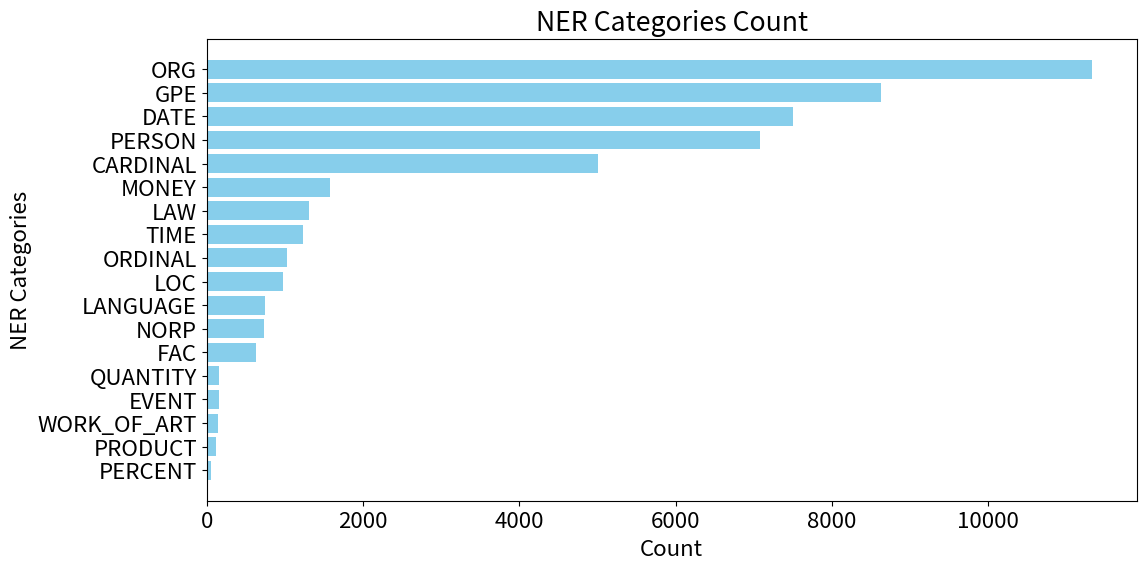

In [ ]:
# 繪製 NER 類別
plt.figure(figsize=(12, 6))
plt.barh(ner_count['ner'], ner_count['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('NER Categories')
plt.title('NER Categories Count')
plt.gca().invert_yaxis()
plt.show()

### NER 類別計數分析

1. 主要類別：
    - ORG（組織）：最常被提及的實體，表明討論中涉及大量關於公司、機構或其他與AI相關的組織。
    - GPE（地理政治實體）：頻繁提及，反映出討論涉及國家、城市或地區，這些地方與AI的發展息息相關。
    - DATE（日期）：經常提及特定日期，這表明討論內容可能涉及AI相關的事件、發佈或時間表。
    - PERSON（人物）：多次提及個人，表明討論涉及AI領域的重要人物，如研究人員、CEO或有影響力的發言人。

2. 中等頻率：
    - CARDINAL（基數）：討論中使用的數字，反映出AI討論中涉及大量的統計、測量或計數內容。
    - MONEY（金額）：提及財務數字，表示討論中涉及AI項目的資金、投資或成本。
    - ORDINAL（序數）：顯示排名或排序的重要性，反映出AI討論中的序列或順序。

3. 較少提及的類別：
    - NORP（民族、宗教或政治團體）：涉及特定群體或社群，與AI討論相關。
    - LOC（地點）：未在GPE中涵蓋的特定地點，顯示與AI相關活動的地點。
    - TIME（時間）：特定時間，反映AI相關活動或事件的時間。

4. 少量提及的類別：
    - LANGUAGE（語言）、EVENT（事件）、QUANTITY（數量）、WORK_OF_ART（藝術品）、FAC（設施）、PRODUCT（產品）、LAW（法律）、PERCENT（百分比）：這些類別提及次數較少，但在AI討論中仍具有特定的相關性，例如AI系統使用的語言、特定事件、數量及法律或藝術方面的內容。

In [ ]:
# 篩選 NER 為 'ORG' 的資料
filter_ner = ['ORG']
org_data = ner_extracted_df[ner_extracted_df['ner'].isin(filter_ner)]
org_data.head()

,sentence,word,ner
6,新聞標題年後轉職最熱門公司出爐前三名台積電華碩台達電,台積電,ORG
7,經濟日報記者葉卉軒台北即時報導,經濟日報,ORG
11,比薪水年後薪水情報兌換最多的前三名公司為台積電華碩台達,台積電華碩台達,ORG
12,其中華碩的兌換次數為,華碩,ORG
15,近年積極擴廠全世界都在看的半導體龍頭台積電,台積電,ORG


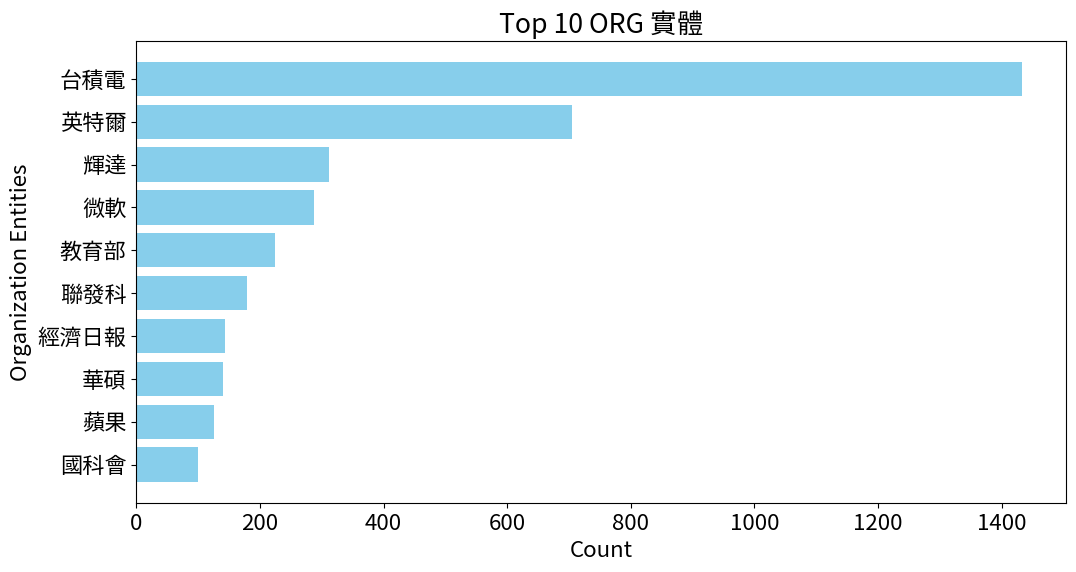

In [ ]:
# 視覺化組織實體
plt.figure(figsize=(12, 6))
plt.barh(org_data
['word'].value_counts().index[:10], org_data['word'].value_counts()[:10], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Organization Entities')
plt.title('Top 10 ORG 實體')
plt.gca().invert_yaxis()
plt.show()

### 圖表分析：前十名組織實體

1. 台積電：
    - 分析：全球的晶圓技術的龍頭，提供最先進的 5nm、3nm 製程，是幾乎所有主要GPU（如 NVIDIA 的 H100／L40、Google 的 TPU 等）的代工夥伴。
    - 影響：大多在討論台積電的布局、股價與訂單展望，以及台積電在國際供應鏈地位對台灣 AI 產業的帶動作用。

2. 英特爾：
    - 分析：橫跨 CPU、GPU 與 FPGA 的晶片大廠，近年透過 Xe GPU 與 Habana AI 加速器進軍資料中心 AI 市場，也持續推進與台積電、三星合作的委外製程。
    - 影響：大多在討論英特爾的新技術、處理器產品或在AI領域的戰略部署。

3. 輝達：
    - 分析：AI 計算領域的龍頭，CUDA 軟體生態與 GPU 架構（Ampere、Hopper）主導了深度學習訓練與推論市場，其 DGX 系列、雲端 GPU 伺服器被廣泛引用。
    - 影響：討論可能涉及其GPU技術、AI開發平台（如CUDA）及其在各種AI應用中的使用。

4. 微軟
    - 分析：微軟是全球領先的科技公司之一，其在AI軟體和雲端服務領域的投入和創新廣為人知。它的頻繁出現顯示出其在AI領域的顯著影響力。
    - 影響：討論涵蓋微軟的AI平台、工具、研究計劃及與其他企業的合作等戰略布局。

5. 教育部：
    - 分析：國家教育主管機關，近年公告 AI 課綱修訂、AI 人才培育計畫，並補助大學及研究機構辦理 AI 相關競賽與工作坊。
    - 影響：多為AI相關活動、公費研習班資訊分享、或新聞，透露出國家機關對AI人才培育的重視。

6. 聯發科：
    - 分析：聯發科是知名的晶片製造商，其產品廣泛應用於各種消費電子設備。其在AI討論中的出現表明其技術在相關應用中的重要性。
    - 影響：大多在討論聯發科的股價新技術、晶片產品或在AI領域的戰略部署。

7. 經濟日報：
    - 分析：財經類主流媒體，定期發布 AI 產業新聞、市場報告及專欄評論，為投資人與產業觀察者提供最新動態。
    - 影響：網友會轉貼該報有關 AI 上市公司財報、產能擴充、國際合作等報導，並在留言中延伸討論政策風向與投資策略。

8. 華碩：
    - 分析：PC 與伺服器硬體廠商，推出 ProArt AI 筆電、AI 伺服器主機板與加速卡，並與 NVIDIA、Intel 合作開發預載 AI 工具的整合方案。
    - 影響：大多在討論華碩的股價、新技術、AI相關硬體產品或戰略部局。


9. 蘋果：
    - 分析：蘋果公司以其創新產品和技術著稱，在AI應用（如Siri、Face ID等）方面也有顯著貢獻。
    - 影響：討論可能集中在蘋果的AI技術發布及其對消費者市場的影響。

10. 國科會：
    - 分析：前身為國家科學委員會，負責國家級科研計畫與補助，已整併為科技部，在 AI 基礎研究、智慧製造與產學合作等面向設有專案補助。
    - 影響：多為網友轉貼新聞，分享國科會對於AI相關晶片、模型的研發補助，透露出國家機關對AI軟硬體發展的重視。

### 缺失的英文組織

在此圖表中，部分重要的英文名稱組織如OpenAI和Google等未能列出，可能是因為CKIP Transformer模型對中文識別效果較好，但對英文名稱識別存在不足。

### 人物實體

In [ ]:
# 篩選 NER 為 'PERSON' 的資料
filter_ner = ['PERSON']
person_data = ner_extracted_df[ner_extracted_df['ner'].isin(filter_ner)]
person_data.head()

,sentence,word,ner
8,經濟日報記者葉卉軒台北即時報導,葉卉軒,PERSON
36,比薪水表示,比薪水,PERSON
39,許永真盼讓百工百業商用,許永真,PERSON
43,永真表示,永真,PERSON
51,台大資工系教授許永真以台灣的與大型語言,許永真,PERSON


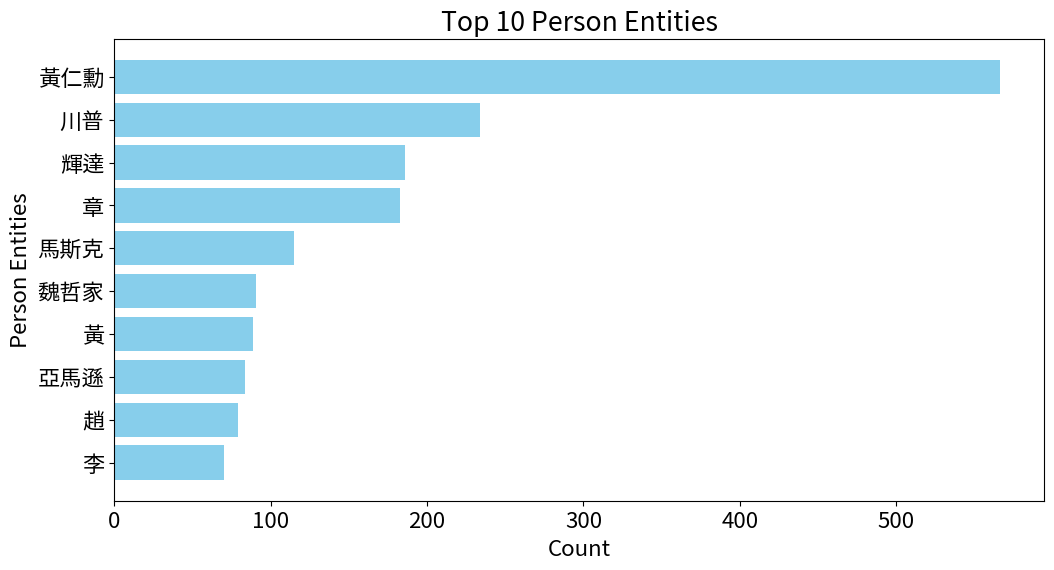

In [ ]:
# 視覺化人物實體
plt.figure(figsize=(12, 6))
plt.barh(person_data['word'].value_counts().index[:10], person_data['word'].value_counts()[:10], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Person Entities')
plt.title('Top 10 Person Entities')
plt.gca().invert_yaxis()
plt.show()

### 圖表分析：前十名人物實體

1. 黃仁勳：
    - 分析：黃仁勳是 NVIDIA 的創辦人兼 CEO，他在 AI 領域中扮演著至關重要的角色。NVIDIA 的 GPU 技術對 AI 和深度學習的發展起到了巨大推動作用。
    - 影響：討論可能涉及他在 AI 領域的技術貢獻、公司戰略及未來規劃。

2. 川普：
    - 分析：任內發起美中貿易戰，對AI晶片加徵關稅與出口管制，並批評台灣廠商瓜分美國市場。
    - 影響：引發鄉民熱議，促使供應鏈重整與中國加速自研晶片。

3. 輝達（NVIDIA）：
    - 分析：輝達是全球領先的 GPU 製造商，其技術對於深度學習和 AI 的計算能力至關重要。這顯示出在 AI 討論中，輝達的技術和產品受到高度關注。
    - 影響：討論可能涉及輝達的 GPU 技術、AI 平台（如 CUDA）、技術創新以及市場競爭力。
    - 備註：輝達被誤認為是人物實體，實際上是組織實體。

4. 馬斯克：
    - 分析：埃隆·馬斯克（Elon Musk）是多家科技公司的創辦人，包括特斯拉和 SpaceX。他在 AI 領域尤其是自動駕駛技術方面有著重要影響，例如 Grok。
    - 影響：討論可能集中在他對 AI 發展的看法、技術創新以及在相關公司的動向。

5. 魏哲家：
    - 分析：作為台積電（TSMC）執行長，魏哲家積極推進 3nm、5nm 等先進製程與 CoWoS 封裝解決方案，並與 NVIDIA、Apple、Google 等一線大廠簽訂長期 AI 晶片代工合約，確保產能與技術領先。
    - 影響：討論多為新聞，介紹tsmc對ai晶片市場的布局。

6. 亞馬遜：
    - 分析：亞馬遜在 AI 技術應用、雲端服務和智能助理（如 Alexa）方面有著重要的地位，顯示出其在 AI 討論中的重要性。
    - 影響：討論可能涉及亞馬遜的 AI 技術應用、AWS 服務及市場策略。
    - 備註：亞馬遜被誤認為是人物實體，實際上是組織實體。

#### 組織被誤判為人物
在分析過程中，我們發現輝達（NVIDIA）、亞馬遜（Amazon）這些組織實體被誤判為人物實體。這反映 CKIP Transformer 模型在識別專有名詞時可能存在一定的誤差，需要進一步改進。

### 事件實體

In [ ]:
# 篩選 NER 為 'EVENT' 的資料
filter_ner = ['EVENT']
event_data = ner_extracted_df[ner_extracted_df['ner'].isin(filter_ner)]
event_data.head()

,sentence,word,ner
877,年度股東大會上談及人工智慧時表示,年度股東大會,EVENT
1356,大馬亞洲防務展台灣軍工業力拚國際市場,大馬亞洲防務展,EVENT
1361,中央社記者黃自強吉隆坡日專電年亞洲防務展和亞洲國家安全展,亞洲防務展,EVENT
1362,中央社記者黃自強吉隆坡日專電年亞洲防務展和亞洲國家安全展,亞洲國家安全展,EVENT
1369,第屆亞洲防務展從日起到日在馬來西亞國際貿易與展覽中心舉行,第屆亞洲防務展,EVENT


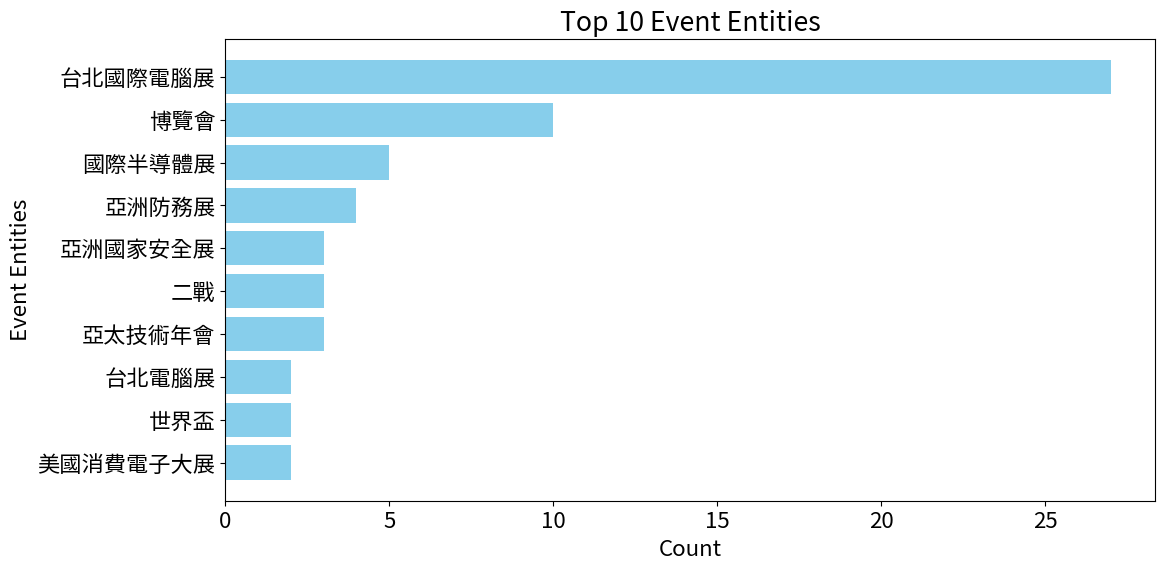

In [ ]:
# 視覺化事件實體
plt.figure(figsize=(12, 6))
plt.barh(event_data['word'].value_counts().index[:10], event_data['word'].value_counts()[:10], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Event Entities')
plt.title('Top 10 Event Entities')
plt.gca().invert_yaxis()
plt.show()

#### 重複事件名稱

雖然有些事件如「烏克蘭戰爭」和「俄烏戰爭」在本質上是同一事件，但由於命名實體識別過程中的重複或不同表述，可能導致數據中的多次計數。

### 修改「台北電腦展」為「台北國際電腦展」

In [ ]:
# 取代「俄烏戰爭」為、為「烏俄戰爭」
event_data.loc[event_data['word'] == '台北電腦展', 'word'] = '台北國際電腦展'
event_data.loc[event_data['word'] == '俄烏戰爭', 'word'] = '烏俄戰爭'

/tmp/ipykernel_668250/324199244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.loc[event_data['word'] == '台北電腦展', 'word'] = '台北國際電腦展'
/tmp/ipykernel_668250/324199244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data.loc[event_data['word'] == '俄烏戰爭', 'word'] = '烏俄戰爭'


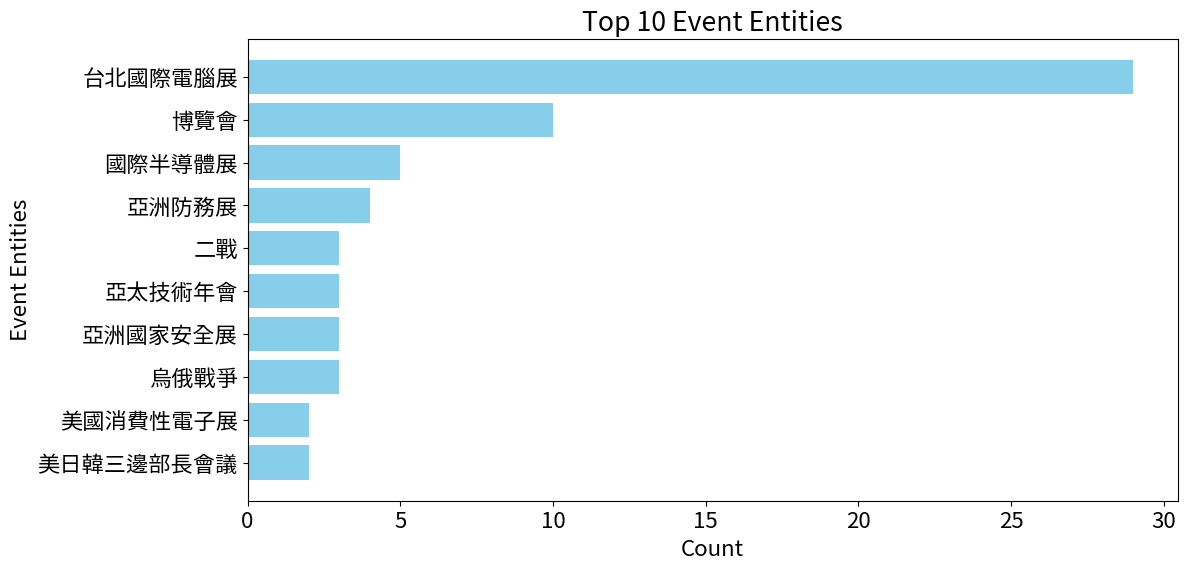

In [ ]:
# 視覺化合併後的事件實體
plt.figure(figsize=(12, 6))
plt.barh(event_data['word'].value_counts().index[:10], event_data['word'].value_counts()[:10], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Event Entities')
plt.title('Top 10 Event Entities')
plt.gca().invert_yaxis()
plt.show()

### 圖表分析：前十名事件實體（合併後）

1. 台北國際電腦展：
    - 分析：台北國際電腦展（COMPUTEX TAIPEI）是全球領先的電腦和科技展覽會，每年吸引眾多科技公司和專業人士參與。它是展示最新科技和創新產品的重要平台。
    - 影響：討論可能涉及展覽會上展示的最新 AI 技術和產品，以及各大公司的參展情況和技術展示，反映出 AI 行業的最新動態和趨勢。

2. 博覽會：
    - 分析：作為對各類科技展覽的通用稱呼，「博覽會」經常出現在討論中，用以概括 COMPUTEX、SEMICON、CES 等不同主題的展覽。PTT 使用者習慣以「博覽會」來討論展會經驗、趨勢觀察與參展心得。
    - 影響：反映出社群對各大科技展的整體關注，說明使用者在搜尋 AI 新技術或產品時，往往會先從博覽會報導與評論著手。

3. 國際半導體展：
    - 分析：例如 SEMICON Taiwan、SEMICON Southeast Asia 等專門聚焦半導體製程與材料的國際級展會，與 AI 晶片製造緊密相關。
    - 影響：凸顯 PTT 上對半導體供應鏈與製造進度的重視，因為晶片技術直接決定 AI 訓練與推論的性能瓶頸。

4. 亞洲防務展：
    - 分析：此展會展示最新國防科技，包括無人機、自動化偵蒐系統與 AI 驅動的防禦平台。PTT 中常出現對防務展上 AI 應用、國產武器系統的討論。
    - 影響：顯示社群對 AI 在國防領域的實戰價值與倫理議題有高度興趣，並持續追蹤國際軍備發展。

5. 二戰：
    - 分析：歷史上最大規模的軍事衝突，「二戰」常被用來做為一個時代的轉捩點。
    - 影響：使用者大多為了敘述美國的現況，AI發展熱潮的一個鋪墊的名詞。

6. 亞太技術年會：
    - 分析：各國政府與業界代表在此年會上交流區域技術政策，包括 AI 產業扶植、標準制定與跨國合作。
    - 影響：反映出決策層面對 AI 發展的重視，PTT 上的討論多聚焦於政策導向、補助資源與法規趨勢。

7. 亞洲國家安全展：
    - 分析：主打網路安全、關鍵基礎設施防護與 AI 防禦方案的專業展會，各大廠牌會展示最新資安產品。
    - 影響：突顯 PTT 使用者對 AI 驅動的資安技術與威脅偵測的需求，以及對國家級資安策略的關切。

8. 烏俄戰爭：
    - 分析：俄烏衝突中大量使用無人機、電子戰與資訊作戰，成為 AI 技術落地的真實戰場案例。
    - 影響：PTT 上透過烏俄戰爭討論 AI 在現代衝突中的角色。

9. 美國消費性電子展：
    - 分析：CES（Consumer Electronics Show）是全球最大規模的消費性電子展，許多 AI 智慧家居、車載系統和機器人首次亮相。
    - 影響：說明 PTT 社群在消費市場對 AI 應用的期待與評測，並透過 CES 報導掌握廠商新動態。

10. 美日韓三邊部長會議：
    - 分析：三國部長級會議中，領袖們討論區域安全、半導體供應與數位經濟合作，AI 產業與政策協調為重要議題之一。
    - 影響：反映社群對國際合作框架下 AI 競爭與治理的關注，並關切三方在技術標準與貿易政策上的協同效應。

### 詞性分析

In [ ]:
pos_count = pd.DataFrame(exploded_data['pos'].value_counts())
pos_count.reset_index(inplace=True)
pos_count.columns = ['pos', 'count']
pos_count

,pos,count
0,Na,199962
1,VC,63299
2,D,53409
3,VH,38338
4,Nc,38047
5,P,28819
6,DE,28201
7,VJ,20013
8,Nf,18658
9,VE,17868


### 繪製詞性類別

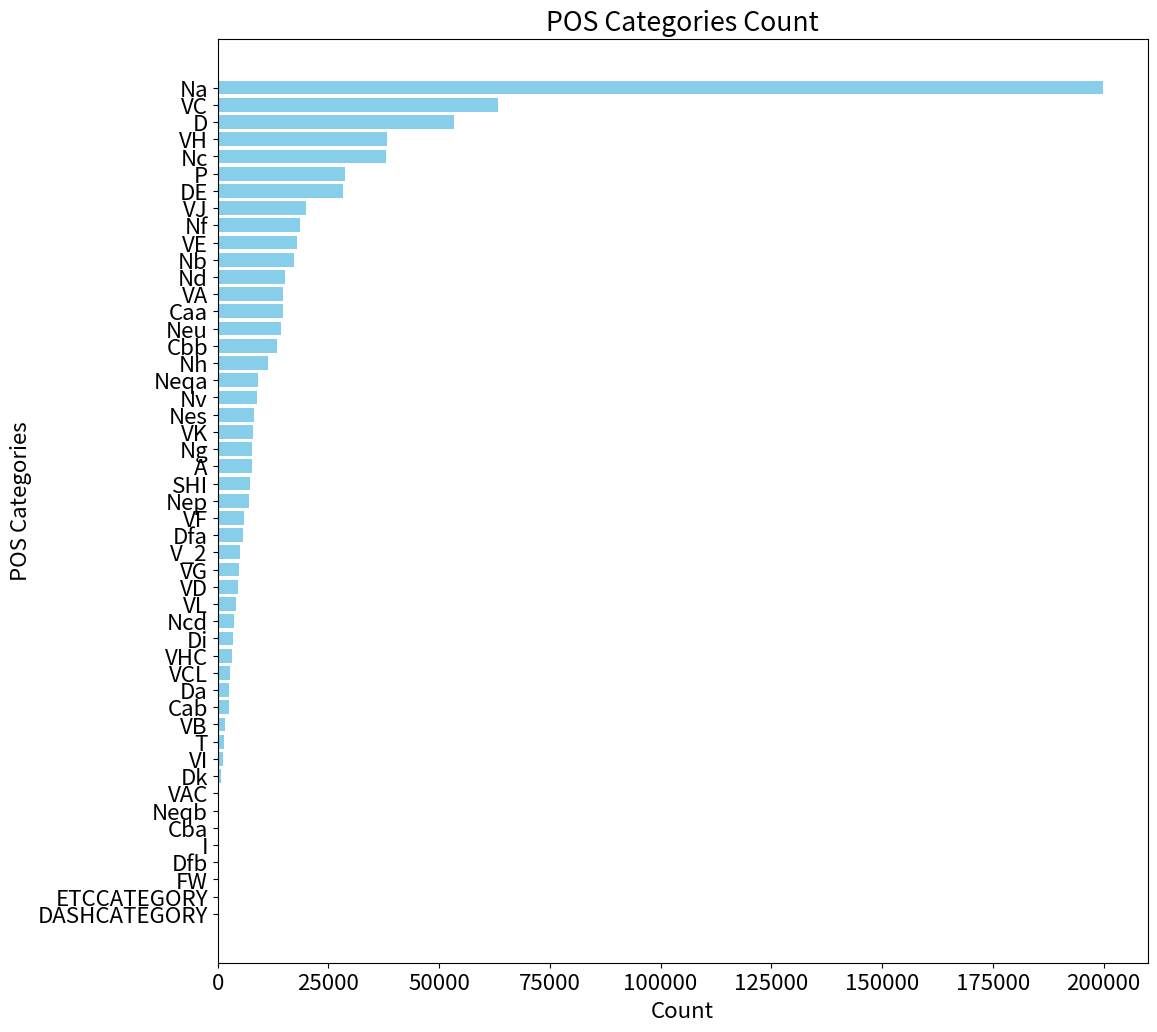

In [ ]:
# 繪製詞性類別
plt.figure(figsize=(12, 12))
plt.barh(pos_count['pos'], pos_count['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('POS Categories')
plt.title('POS Categories Count')
plt.gca().invert_yaxis()
plt.show()

### POS (Part-of-Speech) 前十名分析

以下是對於POS標記前十名及其對應詞彙數量的詳細分析：

1. Na（普通名詞）：
    - 數量：199,962
    - 分析：普通名詞的高頻出現反映了討論中涉及大量具體事物、概念和主題。這些名詞包括具體的物體、場所、組織等。
    - 影響：名詞的頻繁使用有助於確定討論的核心話題和焦點，有助於理解文本的主要內容和關注點。

2. VC（及物動詞）：
    - 數量：63,299
    - 分析：及物動詞用於描述具體的動作和行為，通常後接受詞。高頻的VC表明討論中存在大量的具體行動描述。
    - 影響：分析及物動詞可以了解討論中的主要活動、操作及其對象，有助於理解討論的動態過程。

3. D（副詞）：
    - 數量：53,409
    - 分析：副詞用於修飾動詞、形容詞或其他副詞，提供更多細節和語氣。高頻副詞表明討論中對行動和性質的詳細描述。
    - 影響：副詞的使用可以揭示出討論的細節程度和語氣，幫助更準確地理解文本的語義。

4. VH（形容詞）：
    - 數量：38,338
    - 分析：形容詞用於修飾名詞，提供有關事物的性質、狀態或特徵的描述。高頻形容詞表明討論中對事物特徵的重視。
    - 影響：形容詞的使用可以揭示出討論中對不同事物的評價和看法，有助於理解文本的態度和觀點。

5. Nc（專有名詞）：
    - 數量：38,047
    - 分析：專有名詞指特定的事物或名稱，如地名、人名、品牌名等。高頻專有名詞反映了具體實體在討論中的重要性。
    - 影響：專有名詞的分析有助於識別討論中的主要實體和關鍵詞，理解討論的具體對象。

6. P（介詞）：
    - 數量：28,819
    - 分析：介詞用於表示名詞、代詞與句中其他詞的關係。高頻介詞表明討論中對事物之間關係的描述。
    - 影響：介詞的使用有助於理解句子中的邏輯和語義關係，解析句子的結構。

7. DE（結構助詞）：
    - 數量：28,201
    - 分析：結構助詞「的」用於連接名詞和修飾語，是漢語中最常見的結構詞之一。高頻出現表明句子結構中的常見用法。
    - 影響：結構助詞的使用有助於理解句子的結構和組成部分，有助於解析句子的語法關係。

8. VJ（結構助詞）：
    - 數量：20,013
    - 分析：結構助詞「得」常位於動詞之後，引出補語，表示動作的程度或方式；「地」常置於形容詞或動詞前，將後續詞語作為狀語補充說明。
    - 影響：VJ 的使用能精確地標示動作或性質的細節與程度，幫助解析補語結構及動詞／形容詞與其補語之間的語義關係。

9. Nf（時間名詞）：
    - 數量：18,658
    - 分析：時間名詞如「今天」、「明天」等，表示時間。高頻時間名詞表明討論中對時間的重視。
    - 影響：時間名詞的分析有助於理解討論的時間背景和事件發生的時間點，提供時間軸信息。

10. VE（有詞）：
    - 數量：17,868
    - 分析：有詞如「有」表示存在、擁有等。高頻有詞表明討論中對存在狀態和擁有關係的描述。
    - 影響：有詞的使用有助於理解討論中的擁有關係和存在狀態，解析文本的語義結構。

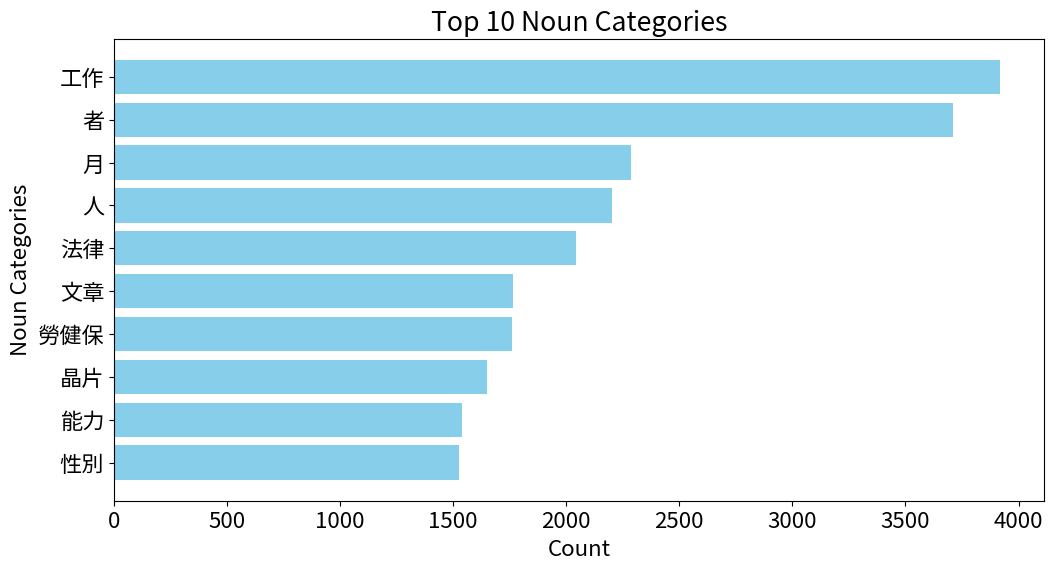

In [ ]:
filter_pos = ['Na']
noun_data = exploded_data[exploded_data['pos'].isin(filter_pos)]

# 視覺化名詞類別
# plt.rcParams['font.family'] = 'Noto Sans TC'
plt.figure(figsize=(12, 6))
plt.barh(noun_data['word'].value_counts().index[:10], noun_data['word'].value_counts()[:10], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Noun Categories')
plt.title('Top 10 Noun Categories')
plt.gca().invert_yaxis()
plt.show()

### 圖表分析：前十名名詞類別

我們可以看到「工作」在名詞類別中出現頻率最高（約 3900 次），這反映出台灣職場對 AI 能力的高度需求，帶動了大量 AI 相關職缺的出現。其次，「晶片」（約 1550 次）凸顯了硬體加速器在 AI 運算中的關鍵角色，說明業界對於效能優化的重視。另一方面，「法律」（約 2100 次）也名列前茅，暗示隨著 AI 技術的快速普及，既有法規面臨挑戰，亟需修訂以因應新興應用與倫理風險。綜合來看，此次詞頻分析不僅呈現了技術端的發展熱點，也突顯了 AI 對勞動市場與法制環境的深遠影響。

## 結論

通過對 AI 相關文本數據的 NER 和 POS 分析，我們可以獲得以下結論：

1. 組織實體：出現頻率最高的組織包括 NVIDIA、TSMC、Amazon 等，討論核心圍繞晶片製造商與雲端平台的市場競爭與技術布局，顯示使用者對供應鏈動態與技術可擴展性的高度關注。
2. 人物實體：頻繁被提及的黃仁勳、魏哲家、Elon Musk 等，代表了各自企業在 AI 領域的技術與市場影響力。這些人物常成為 PTT 鄉民討論的焦點，用以解讀公司策略、產能分配與技術創新對產業走向的意義。
3. 事件實體：以台北國際電腦展、國際半導體展、CES 等技術博覽會為主，顯示展示平台是社群掌握最新 AI 技術與產品的主要來源。
4. 詞性分析：普通名詞最為高頻，說明 PTT 討論高度聚焦於具體事物與概念本身；及物動詞、副詞的頻繁使用則揭示了動作描述與細節修飾的豐富性。
5. 名詞類別：「工作」、「晶片」、「能力」、「法律」等詞彙出現頻次最高，分別對應 AI 技術對職場的影響、硬體核心技術、模型與人員能力要求，以及法規與倫理挑戰。